In [3]:
# Load API_key from .env file
from config_loader import ConfigLoader
config = ConfigLoader()

In [15]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=2)

# This executes code locally, which can be unsafe
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [6]:
from langgraph.graph import MessagesState

In [7]:
# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str

In [8]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic

members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


def supervisor_node(state: AgentState) -> AgentState:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    next_ = response["next"]
    if next_ == "FINISH":
        next_ = END

    return {"next": next_}

In [9]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. DO NOT do any math."
)


def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="researcher")
        ]
    }


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: AgentState) -> AgentState:
    result = code_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="coder")]
    }


builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)

In [10]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    builder.add_edge(member, "supervisor")

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
builder.add_conditional_edges("supervisor", lambda state: state["next"])
# Finally, add entrypoint
builder.add_edge(START, "supervisor")

graph = builder.compile()

In [11]:
from IPython.display import display, Image

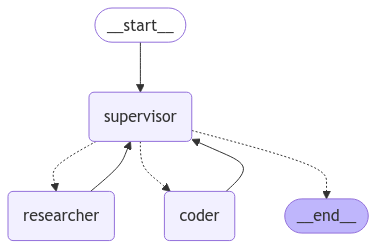

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'coder'}})
----


Python REPL can execute arbitrary code. Use with caution.


(('coder:c2ab2872-50c5-a774-f57b-959da3548b44',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you calculate the square root of 42 using Python.", 'type': 'text'}, {'id': 'toolu_01RXPcxDJF5dgPCxhrP3J6be', 'input': {'code': 'import math\nprint(math.sqrt(42))'}, 'name': 'python_repl_tool', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01NTZecRCETzfwacV2pc8dXa', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 435, 'output_tokens': 82}}, id='run-ca615f56-7508-4052-bd40-1fc4c4e95c57-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'toolu_01RXPcxDJF5dgPCxhrP3J6be', 'type': 'tool_call'}], usage_metadata={'input_tokens': 435, 'output_tokens': 82, 'total_tokens': 517, 'input_token_details': {}})]}})
----
(('coder:c2ab2872-50c5-a774-f57b-959da3548b44',), {'tools': {'messages': [ToolMessage(content='Successfully executed:\n\\`\\`

In [14]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:1fd53d85-aefa-a0c2-1cb0-6c01ba16d4a8',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you search for the latest GDP data for New York and California. However, as per my instructions, I won't perform the mathematical calculations myself.\n\nLet me search for this information:", 'type': 'text'}, {'id': 'toolu_01HN1CDPvXMxzMK2vc5eCEK9', 'input': {'query': 'latest GDP of New York state 2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Q7BqYF4BUjYAPvBfLDrSiP', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 442, 'output_tokens': 107}}, id='run-c50f84a1-d337-47ae-9c19-69e2bbe593de-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest GDP of New York state 2023'}, 'id': 'toolu_01HN1CDPvXMxzMK2vc5eCEK9', 'type': 'tool_call'}], usage_metadata={'input_